# AES Differential and Correlation and ... Power Analysis

<img src='images/DoIt.png' style='width: 100px'>

# EXAMPLE


## Remember:

<img src='images/CPA formula.png' style='width: 600px'>


#### Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
    
plt.rcParams["figure.figsize"] = [20, 5]

<img src='images/DoIt.png' style='width: 100px'>

#### Load the trace 'AES_traces_set_1st_round.ets'
from SideSCA-Traces-Public: git clone https://github.com/BeneoLix/SideSCA-Traces-Public.git

---
<img src='images/DoIt.png' style='width: 100px'>

## Import the traces needed for the analysis

In [3]:
import estraces

In [4]:
ths = estraces.read_ths_from_ets_file("../SideSCA-Traces-Public/AES_xmega_traces_set_NewAE.ets") 

---
<img src='images/DoIt.png' style='width: 100px'>

#### Print the ths information, the ths len


In [5]:
print(ths)

Trace Header Set:
Name.............: ETS Format THS
Reader...........: ETS format reader of file ../SideSCA-Traces-Public/AES_xmega_traces_set_NewAE.ets with 50 traces.
key..............: uint8
plaintext........: uint8



---
<img src='images/DoIt.png' style='width: 100px'>

## Plot and Observe  the traces


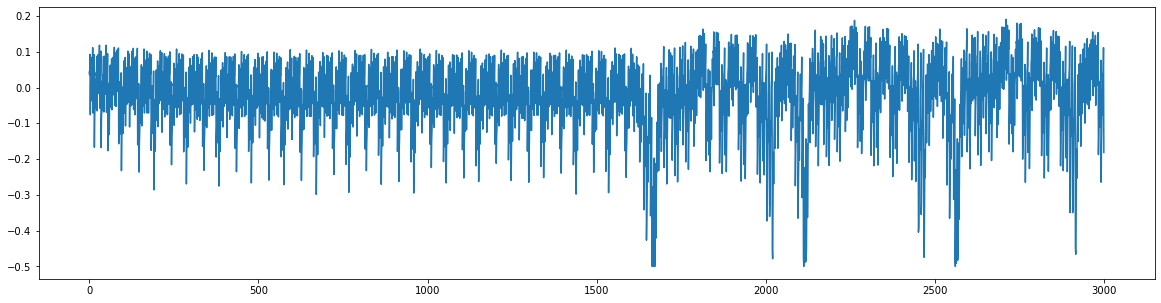

In [6]:
plt.plot(ths[0].samples.T)
plt.show()

----
<img src='images/DoIt.png' style='width: 100px'>

## Attack the first round with DPA

Can you recover the key ?

In [7]:
len(ths)

50

In [8]:
ths.metadata_tags

['key', 'plaintext']

In [9]:
import estraces
import scared

In [10]:
import numpy as np

In [11]:
# Create a container for your ths
container = scared.Container(ths)

In [12]:
attack_dpa = scared.DPAAttack(
        selection_function=scared.aes.selection_functions.encrypt.FirstSubBytes(),
        model=scared.Monobit(0),
        discriminant=scared.maxabs,
        convergence_step=len(ths)//5    
    )

In [13]:
attack_dpa.run(container)

In [14]:
attack_dpa.results.shape

(256, 16, 3000)

In [15]:
found_key = attack_dpa.scores.argmax(0).squeeze()

In [16]:
vhex = np.vectorize(hex)
print("the key found is:   ", vhex(found_key))
print("the correct key is: ", vhex(ths[0].key))

the key found is:    ['0x92' '0xd7' '0x33' '0x21' '0x55' '0x3' '0x24' '0x74' '0x7' '0xfb'
 '0x44' '0x36' '0xb' '0xb7' '0x29' '0x54']
the correct key is:  ['0x2b' '0x7e' '0x15' '0x16' '0x28' '0xae' '0xd2' '0xa6' '0xab' '0xf7'
 '0x15' '0x88' '0x9' '0xcf' '0x4f' '0x3c']


In [17]:
attack_dpa.scores.shape

(256, 16)

In [18]:
attack_dpa.convergence_traces.shape

(256, 16, 5)

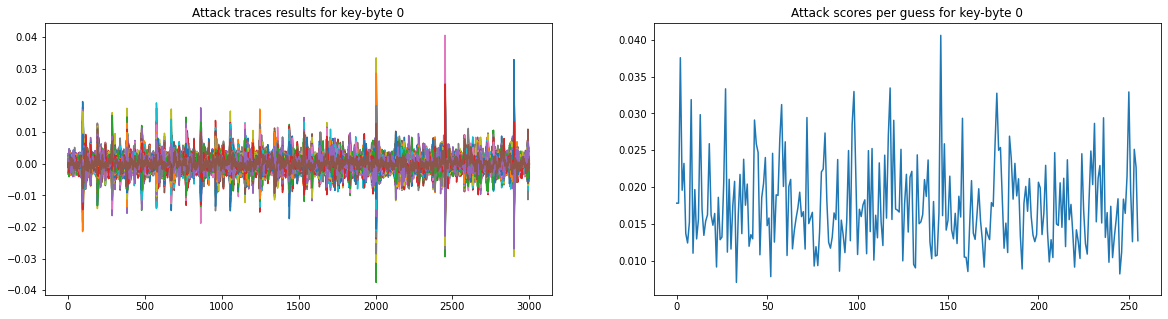

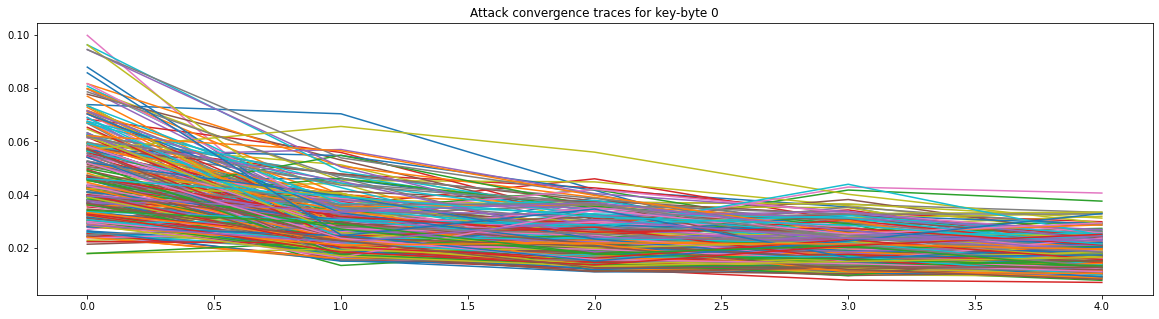

In [19]:
key_byte = 0
plt.subplot(1,2,1)
plt.title('Attack traces results for key-byte '+str(key_byte))
plt.plot(attack_dpa.results.T[:,key_byte,:])
plt.subplot(1,2,2)
plt.title('Attack scores per guess for key-byte '+str(key_byte))
plt.plot(attack_dpa.scores[:,key_byte])
plt.show()
plt.title('Attack convergence traces for key-byte '+str(key_byte))
plt.plot(attack_dpa.convergence_traces.T[:,key_byte, :])
plt.show()

----
<img src='images/DoIt.png' style='width: 100px'>

## Attack the first round with CPA

Can you recover the key ?

In [19]:
attack_cpa = scared.CPAAttack(
        selection_function=scared.aes.selection_functions.encrypt.FirstSubBytes(),
        model=scared.HammingWeight(),
        discriminant=scared.maxabs,
        convergence_step=len(ths)//5    
    )

In [20]:
attack_cpa.run(container)

In [21]:
attack_cpa.results.shape

(256, 16, 3000)

In [22]:
found_key = attack_cpa.scores.argmax(0).squeeze()

In [23]:
vhex = np.vectorize(hex)
print("the key found is:   ", vhex(found_key))
print("the correct key is: ", vhex(ths[0].key))

the key found is:    ['0x2b' '0x7e' '0x15' '0x16' '0x28' '0xae' '0xd2' '0xa6' '0xab' '0xf7'
 '0x15' '0x88' '0x9' '0xcf' '0x4f' '0x3c']
the correct key is:  ['0x2b' '0x7e' '0x15' '0x16' '0x28' '0xae' '0xd2' '0xa6' '0xab' '0xf7'
 '0x15' '0x88' '0x9' '0xcf' '0x4f' '0x3c']


In [24]:
attack_cpa.scores.shape

(256, 16)

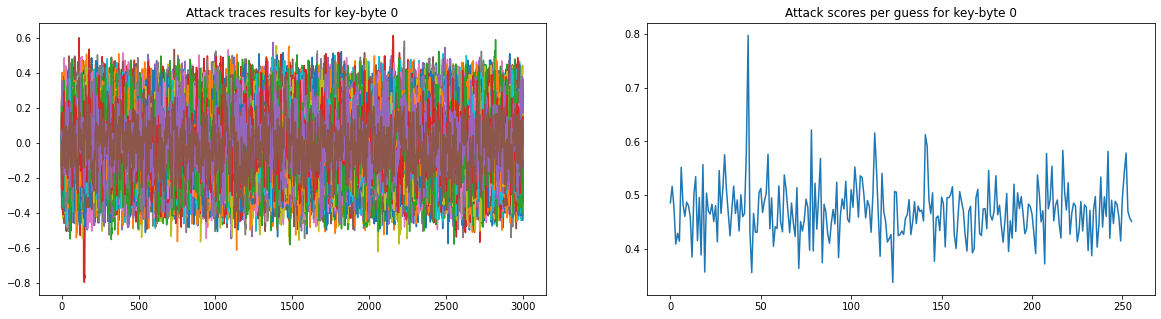

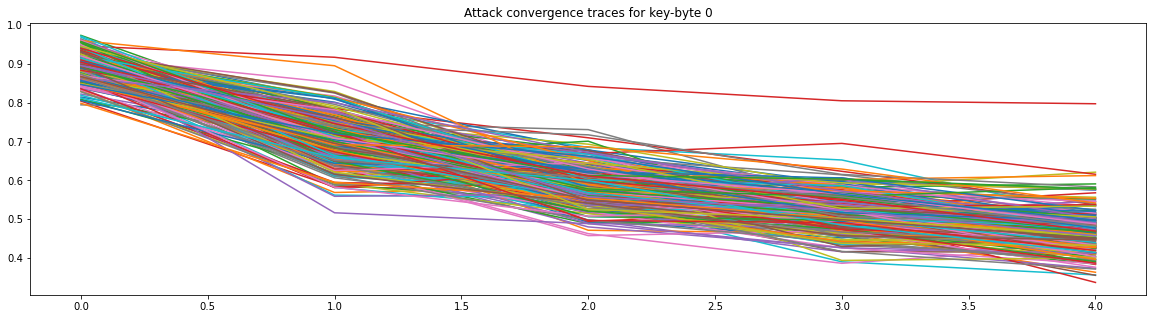

In [36]:
key_byte = 0
plt.subplot(1,2,1)
plt.title('Attack traces results for key-byte '+str(key_byte))
plt.plot(attack_cpa.results.T[:,key_byte,:])
plt.subplot(1,2,2)
plt.title('Attack scores per guess for key-byte '+str(key_byte))
plt.plot(attack_cpa.scores[:,key_byte])
plt.show()
plt.title('Attack convergence traces for key-byte '+str(key_byte))
plt.plot(attack_cpa.convergence_traces.T[:,key_byte, :])
plt.show()

----
<img src='images/DoIt.png' style='width: 100px'>

## Why not testing other distinguishers like SNR? ANOVA? NICV?


## Partitioning attacks i.e. ANOVA, NICV and SNR
-----------------------

On the one hand, as presented in the [Correlation Power Analysis knowledge notebook](Knowledge-Correlation_Power_Analysis.ipynb),  the **correlation** principle is to evaluate linear dependencies between two groups.

On the other hand, **partitioning** analyses consist in comparing statistical moments of two or more groups to determine if the partitions were chosen correctly.
Together with the *Difference of Means* (DoM) [Standaert et al., 2008], the *Signal-to-Noise Ratio* (SNR), the *Normalized Inter-Class Variance* (NICV) [Bhasin et al., 2013], the *Analysis of Variance* (ANOVA) are all *F-tests* used for comparing the factors of the total deviation.
Those methods are sensitive to non-normality.

The ANOVA *F-test* statistic is defined as:
$ F = \displaystyle\frac{\text{inter-group variance}}{\text{intra-group variance}}$



- **inter-group** variance:
$ \displaystyle\sum_{i=1}^{K} =  \displaystyle\frac{n_i(\mu_i - \mu)^2}{K-1} $, with
  - $n_i$, the number of samples in the $i$-th group.
  - $\mu_i$, the sample mean in the $i$-th group.
  - $\mu$, the overall sample mean.
  - $K$, the number of groups.


- **intra-group** variance: 
$ \displaystyle\sum_{i=1}^{K}\displaystyle\sum_{j=1}^{n_i}  \displaystyle\frac{(Y_{ij} - \mu_i)^2}{N-K} $, with
  - $Y_{ij}$, the $j$-th sample in the $i$-th group.
  - $N$, the overall number of samples. 

In [39]:
attack_anova = scared.ANOVAAttack(
        selection_function=scared.aes.selection_functions.encrypt.FirstSubBytes(),
        model=scared.HammingWeight(),
        discriminant=scared.maxabs,
        convergence_step=len(ths)//5    
    )

In [40]:
attack_anova.run(container)

In [41]:
attack_anova.results.shape

(256, 16, 3000)

In [42]:
found_key = attack_anova.scores.argmax(0).squeeze()

In [43]:
vhex = np.vectorize(hex)
print("the key found is:   ", vhex(found_key))
print("the correct key is: ", vhex(ths[0].key))

the key found is:    ['0x2b' '0x7e' '0x15' '0xe1' '0x28' '0xae' '0xd2' '0xa6' '0x9f' '0xf7'
 '0x15' '0x88' '0x9' '0xcf' '0x4f' '0x3c']
the correct key is:  ['0x2b' '0x7e' '0x15' '0x16' '0x28' '0xae' '0xd2' '0xa6' '0xab' '0xf7'
 '0x15' '0x88' '0x9' '0xcf' '0x4f' '0x3c']


In [44]:
attack_anova.scores.shape

(256, 16)

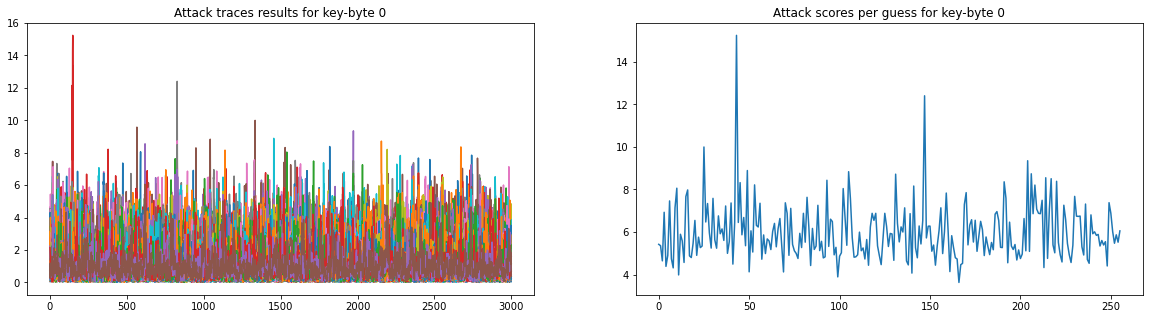

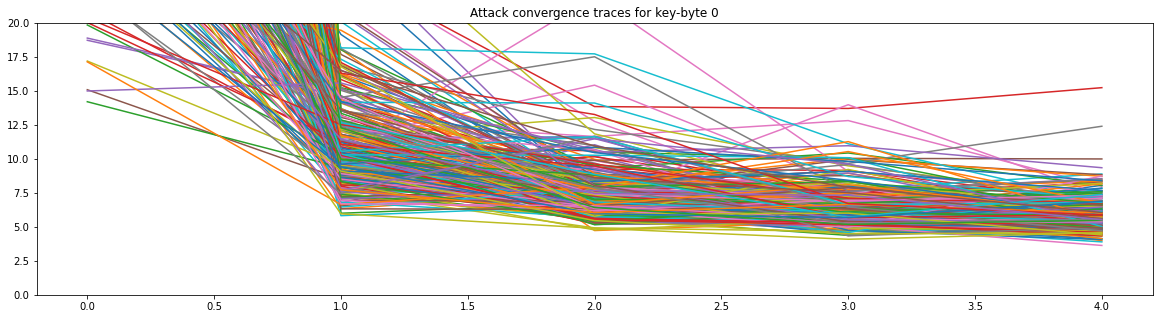

In [47]:
key_byte = 0
plt.subplot(1,2,1)
plt.title('Attack traces results for key-byte '+str(key_byte))
plt.plot(attack_anova.results.T[:,key_byte,:])
plt.subplot(1,2,2)
plt.title('Attack scores per guess for key-byte '+str(key_byte))
plt.plot(attack_anova.scores[:,key_byte])
plt.show()
plt.title('Attack convergence traces for key-byte '+str(key_byte))
plt.plot(attack_anova.convergence_traces.T[:,key_byte, :])
plt.ylim(0, 20)
plt.show()